## Global variables

In [1]:
redo_training = True

path_to_text_classifiers = 'pickle_files/text_classifiers_2020-01-15_16-22.pickle'

## Importing librairies

In [2]:
import sys,os,importlib

#Checking the packages version
!{sys.executable} -m pip install -r requirements.txt

#Adding path to custom module
module_path = os.path.abspath(os.path.join('python_files/'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Importing custom module
import utils

#If utils.py modified run this command  
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\ppike\\Documents\\GitHub Repositories\\Portfolio\\python_files\\utils.py'>

In [3]:
import glob,pickle, datetime, wordcloud, string,time

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image

from joblib import parallel_backend

# Building dataset

In [4]:
train_positive_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/train/pos/*.txt')
train_negative_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/train/neg/*.txt')

test_positive_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/test/pos/*.txt')
test_negative_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/test/neg/*.txt')

In [5]:
train_data = []
train_target = []

positive_reviews = []
negative_reviews = []

for path in train_positive_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    train_data.append(text)
    train_target.append(1)
    positive_reviews.append(text)
    
for path in train_negative_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    train_data.append(text)
    train_target.append(0)
    negative_reviews.append(text)

In [6]:
test_data = []
test_target = []

for path in test_positive_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    test_data.append(text)
    test_target.append(1)
    positive_reviews.append(text)
    
for path in test_negative_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    test_data.append(text)
    test_target.append(0)
    negative_reviews.append(text)

In [7]:
print('training size:',len(train_data),'\ntest size:',len(test_data))

training size: 25000 
test size: 25000


# Adjectives representing positive and negative reviews

In [8]:
#nltk is a library for natural language processing
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ppike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ppike\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
def pre_process(corpus):
    #Converting the text to lower case
    corpus = corpus.lower()
    
    #Defining stopwords
    stopset = stopwords.words('english') + list(string.punctuation)+['br','nt']
    
    #Isolating each word of the text and removing stopwords
    tokens = [i for i in word_tokenize(corpus) if i not in stopset]
    
    #Lemmatizing words
    lemmatizer = WordNetLemmatizer()
    lems = [lemmatizer.lemmatize(word=item) for item in tokens]
    
    #Joining back the words lemmatize with no stop words
    corpus = " ".join(lems)
    
    return corpus

Lemmatization example: playing -> play ; played -> play ; playfull -> play

In [11]:
#Joining all the positive reviews and preprocessing them
start_time = time.time()

text_pos = ' '.join(positive_reviews)
text_pos = pre_process(text_pos)

end_time = time.time()
print('Executed in : ',end_time-start_time,'s')

Executed in :  64.59310603141785 s


In [12]:
#Joining all the negative reviews and preprocessing them
start_time = time.time()

text_neg = ' '.join(negative_reviews)
text_neg = pre_process(text_neg)

end_time = time.time()
print('Executed in : ',end_time-start_time,'s')

Executed in :  60.065868616104126 s


In [13]:
corpus = [text_pos,text_neg]

In [14]:
#Note: TfidfVectorizer is a combination of CountVectorizer and TfidfTransformer
tfidf_vectorizer = TfidfVectorizer()

with parallel_backend('threading',n_jobs=-1):
    feature_vectors = tfidf_vectorizer.fit_transform(corpus)
    feature_names = tfidf_vectorizer.get_feature_names()

In [15]:
def get_adjectives(document):
    doc = document

    tfidf_scores = []
    words = []
    
    #Keeping values different than zeros
    nz = doc.nonzero()

    #Getting words and their tfidf score
    for i,j in zip(nz[0],nz[1]):
        words.append(feature_names[j])
        tfidf_scores.append(doc[i,j])

    tfidf_table = pd.DataFrame()
    tfidf_table['Word'] = words
    tfidf_table['Score'] = tfidf_scores
    
    #Tagging every words either it is a name, adjective, verb etc ..
    tfidf_table['Tag'] = nltk.pos_tag(tfidf_table['Word'])
    
    #Keeping only the tag, the pos_tag output is (word,tag)
    tags = pd.DataFrame(tfidf_table['Tag'].tolist(),index=tfidf_table.index)
    tfidf_table['Tag'] = tags[1]
    
    #Ordering to have the most relevant words at the top
    tfidf_table.sort_values(by='Score',ascending=False,inplace=True)
    
    #Isolating adjectives
    adjectives = tfidf_table.where(tfidf_table['Tag'] == 'JJ')
    adjectives.dropna(inplace=True)
    
    return adjectives

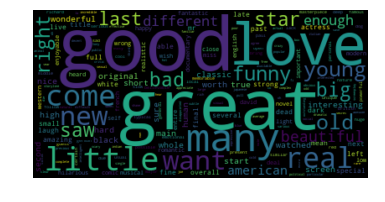

In [16]:
#Drawing wordcloud of adjectives for positive reviews
pos_adj = get_adjectives(feature_vectors[0])

wc = wordcloud.WordCloud()
wc = wc.generate_from_frequencies(dict(zip(pos_adj['Word'],pos_adj['Score'])))

plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

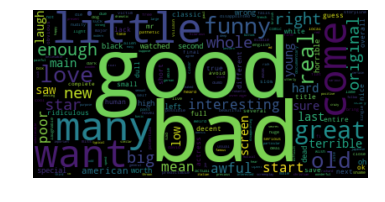

In [17]:
#Drawing wordcloud of adjectives for negative reviews
neg_adj = get_adjectives(feature_vectors[1])

wc = wordcloud.WordCloud()
wc = wc.generate_from_frequencies(dict(zip(neg_adj['Word'],neg_adj['Score'])))

plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

Notice that the words like good, great or funny are likely to be preceded with the word not. To make this appear a bigram analysis should be done. It could be an improvement for this notebook. We can still see words that clearly describe bad reviews as: awful, stupid or poor.

# Text Classifiers

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [19]:
from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import tree

import sklearn.metrics as metrics


classifiers = [
    KNeighborsClassifier(n_jobs=-1),
    #SVC(), --- Long to compute 
    ##GaussianProcessClassifier(n_jobs=-1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10,n_jobs=-1),
    #MLPClassifier(), --- Long to compute 
    AdaBoostClassifier(),
    ##GaussianNB(),
    ##QuadraticDiscriminantAnalysis(),
    SGDClassifier(n_jobs=-1),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=10,n_jobs=-1),
    GradientBoostingClassifier(),
    ##HistGradientBoostingClassifier()
]

names = []

#Getting classifiers names
for clf in classifiers:
    names.append(str(clf).split('(')[0])

Notice that the estimators :
- GaussianProcessClassifier, GaussianNB, QuadraticDiscriminantAnalysis, HistGradientBoostingClassifier are needing a dense matrix as input (the actual input is a sparse matrix). I tried to implement a specific pipeline, but RAM available was insufficient.
- SVC and MLPClassifier are quite long to train (around 10 minutes) with Intel corei7 7th Gen processor.

KNeighborsClassifier 0.66152
Executed in : 62.2395875453949 seconds

DecisionTreeClassifier 0.70552
Executed in : 47.09091305732727 seconds

RandomForestClassifier 0.73364
Executed in : 12.469603538513184 seconds

AdaBoostClassifier 0.8034
Executed in : 35.82399797439575 seconds

SGDClassifier 0.88532
Executed in : 9.903464555740356 seconds

BaggingClassifier 0.77628
Executed in : 310.2230396270752 seconds

ExtraTreesClassifier 0.74524
Executed in : 14.189221620559692 seconds

GradientBoostingClassifier 0.81416
Executed in : 121.34052085876465 seconds

text_classifierswas saved in pickle_files/text_classifiers_2020-01-15_18-47.pickle


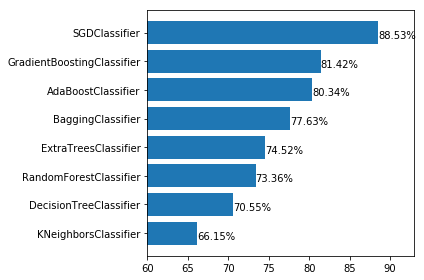

In [20]:
text_classifiers = []
scores = []

if redo_training == True:
    for (clf,name) in zip(classifiers,names):
        
        #Building Pipeline
        text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)])
        
        start_time = time.time()
        
        with parallel_backend('threading',n_jobs=-1):
            
            #Training the model
            text_clf.fit(train_data,train_target)
            
            #Computing accuracy score
            predictions = text_clf.predict(test_data)
            score = metrics.accuracy_score(predictions,train_target)
            scores.append(score)
            print(name,score)
                  
        end_time = time.time()
        print('Executed in :',end_time-start_time,'seconds\n')
        text_classifiers.append(text_clf)
     
    utils.plot_scores(scores,names)
    
    #Saving data to pickle file
    utils.save_to_pickle((text_classifiers,scores),'text_classifiers')
    
else:
    text_classifiers,scores = pickle.load(open(path_to_text_classifiers,'rb'))
    utils.plot_scores(scores,names)

The SVC is best model but it is very long to compute. The SGDClassifier is a bit less accurate but more efficient. We will select this model for the predictions.

Executed in 95.16373467445374 s


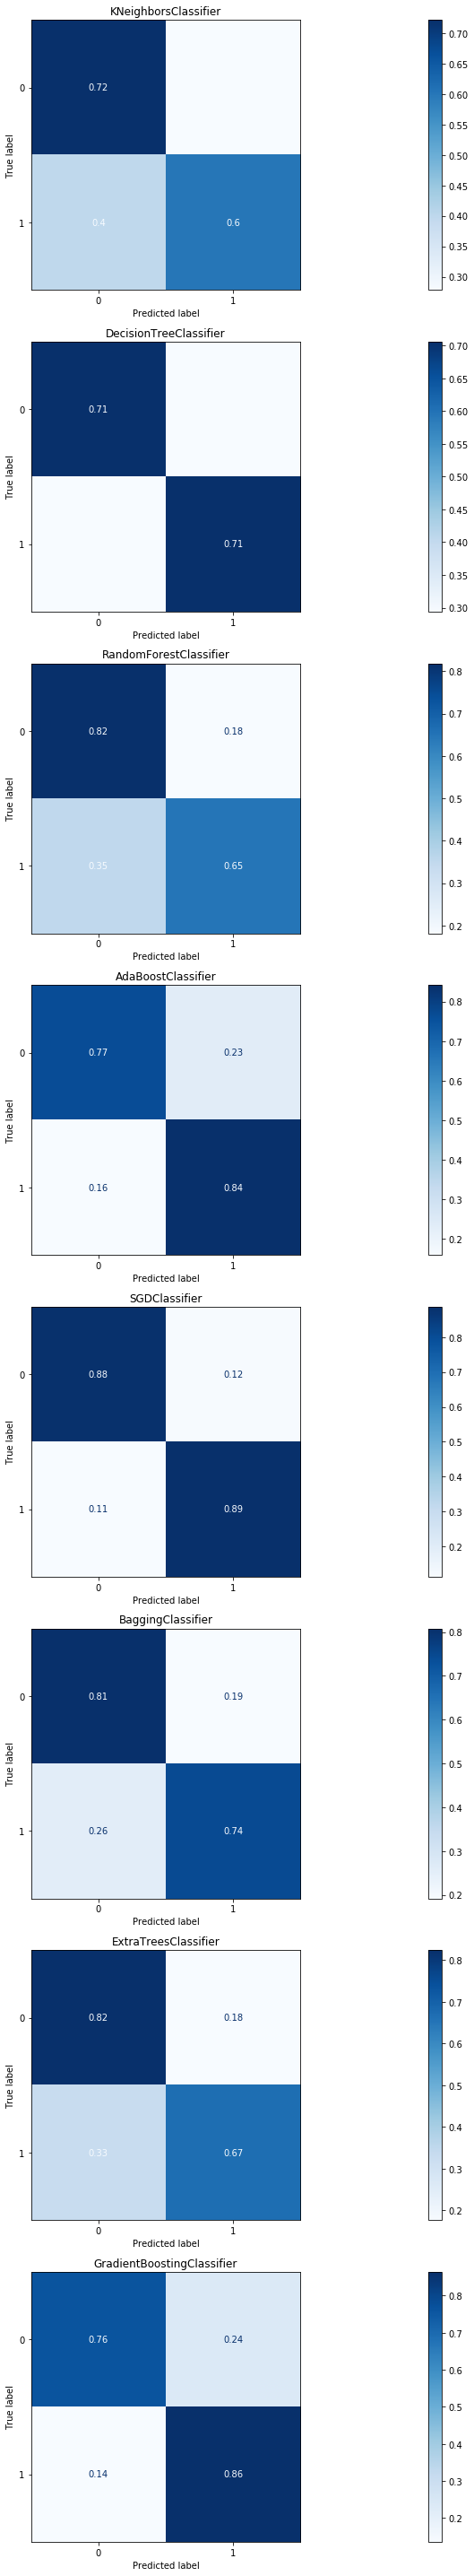

In [21]:
#Plotting confusion matrices
if redo_training == True:
    fig,axis = plt.subplots(len(text_classifiers),1,figsize=(40,40))
    plots = []

    start_time = time.time()

    for text_clf,ax,name in zip(text_classifiers,axis,names):
        ax.set_title(name)
        #Computing confusion matrix
        metrics.plot_confusion_matrix(text_clf,test_data,test_target,normalize='true',cmap=plt.cm.Blues, ax=ax)
        
    plt.tight_layout()
    end_time = time.time()
    print('Executed in',end_time-start_time,'s')
    
    #Savings plots to png image
    fig.savefig('graphics/text_classifiers_confusion_matrices.png')
else:
    im = Image.open(r"graphics/text_classifiers_confusion_matrices.png")
    im.show()

We can conclude that the SVC and SGDClassifer are the most accurate models. We will select the SGDClassifier for predicting, because it is quicker to compute than the SVC model. 